In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import mlflow.sklearn
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve

Read Data and Select Feature for Predict Campaign Response using Behavioral Credit Card Usage from Transaction Data

In [29]:
file_path_cc = r''
cust_cc_df = pd.read_csv(file_path_cc)
cust_cc_df = cust_cc_df.drop(columns=['Age', 'Gender', 'Income', 'Marital_Status', 'Number_of_Dependents', 'Days_as_Customer'])
cust_cc_df.sort_values(by=['Customer_ID', 'Feature_Date'], ascending=True).head()

,Customer_ID,Feature_Date,Total_Credit_Limit,Average_Monthly_Spend,Number_of_Transactions_Per_Month,Number_of_Merchants_Per_Month,Spend_Category,Credit_Limit_Utilization,Number_of_Overdue_Payments_12_Months,Number_of_Payments_in_Full_12_Months,...,Days_Since_Last_Transaction,Avg_Spend_Per_Transaction,High_Value_Transactions,Num_Spend_Categories,Avg_Days_Between_Transactions,Times_Credit_Limit_Exceeded,Previous_Month_Payment,Times_Payment_Missed,Target,Target_Date
0,66000001,2023-01-31,82217.29,1930.89,24,4,Entertainment,0.69,1,10,...,20,80.45,3,4,1.25,0,1201.09,0,0.00,2023-03-31
1,66000001,2023-02-28,82217.29,1224.78,14,17,Entertainment,0.70,0,6,...,17,87.48,2,4,2.14,0,950.43,0,0.00,2023-04-28
2,66000001,2023-03-31,82217.29,5124.95,25,7,Dining,0.46,0,7,...,0,205.00,3,1,1.20,0,4173.54,0,0.00,2023-05-31
3,66000001,2023-04-30,82217.29,27245.48,23,7,Dining,0.78,0,7,...,9,1184.59,1,1,1.30,0,24625.45,0,0.00,2023-06-30
4,66000001,2023-05-31,82217.29,7766.68,12,7,Dining,0.37,0,5,...,22,647.22,2,4,2.50,0,11521.27,0,0.00,2023-07-31


Features Lagged by 2 Months from Target

In [8]:
cust_cc_df.groupby(['Feature_Date', 'Target_Date']).agg({'Customer_ID': 'count'}).reset_index()

,Feature_Date,Target_Date,Customer_ID
0,2023-01-31,2023-03-31,1000
1,2023-02-28,2023-04-28,1000
2,2023-03-31,2023-05-31,1000
3,2023-04-30,2023-06-30,1000
4,2023-05-31,2023-07-31,1000
5,2023-06-30,2023-08-30,1000
6,2023-07-31,2023-09-30,1000
7,2023-08-31,2023-10-31,1000
8,2023-09-30,2023-11-30,1000
9,2023-10-31,2023-12-31,1000


Descriptive Data

In [30]:
pd.set_option('display.float_format', '{:.2f}'.format)
cust_cc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_ID,10000.00,66000500.50,288.69,66000001.00,66000250.75,66000500.50,66000750.25,66001000.00
Total_Credit_Limit,10000.00,257898.00,138773.64,5243.46,139931.85,261380.65,376557.40,499755.07
Average_Monthly_Spend,10000.00,15226.44,8636.75,200.54,7681.92,15153.04,22764.51,29987.96
Number_of_Transactions_Per_Month,10000.00,25.05,14.03,1.00,13.00,25.00,37.00,49.00
Number_of_Merchants_Per_Month,10000.00,10.01,5.49,1.00,5.00,10.00,15.00,19.00
Credit_Limit_Utilization,10000.00,0.55,0.26,0.10,0.32,0.54,0.77,1.00
Number_of_Overdue_Payments_12_Months,10000.00,0.47,0.87,0.00,0.00,0.00,1.00,4.00
Number_of_Payments_in_Full_12_Months,10000.00,8.01,2.00,5.00,6.00,8.00,10.00,11.00
Number_of_Late_Payments_12_Months,10000.00,0.24,0.53,0.00,0.00,0.00,0.00,2.00
Average_Payment_Amt,10000.00,14475.67,8600.29,149.91,7146.89,14272.76,21082.19,35862.69


In [31]:
cust_cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Customer_ID                           10000 non-null  int64  
 1   Feature_Date                          10000 non-null  object 
 2   Total_Credit_Limit                    10000 non-null  float64
 3   Average_Monthly_Spend                 10000 non-null  float64
 4   Number_of_Transactions_Per_Month      10000 non-null  int64  
 5   Number_of_Merchants_Per_Month         10000 non-null  int64  
 6   Spend_Category                        10000 non-null  object 
 7   Credit_Limit_Utilization              10000 non-null  float64
 8   Number_of_Overdue_Payments_12_Months  10000 non-null  int64  
 9   Number_of_Payments_in_Full_12_Months  10000 non-null  int64  
 10  Number_of_Late_Payments_12_Months     10000 non-null  int64  
 11  Average_Payment_

Preparing Data for Machine Learning Model

In [32]:
def as_type(df):

    key_cols = ['Customer_ID', 'Feature_Date', 'Target_Date', 'Target']

    cat_cols = list()
    int_cols = list()
    float_cols = list()

    for col in df.columns:
        if col not in key_cols:
            if df[col].dtype == 'object':
                cat_cols.append(col)
            elif df[col].dtype == 'int64':
                int_cols.append(col)
            else:
                float_cols.append(col)

    print("cat_columns:", len(cat_cols))
    print("int_columns:", len(int_cols))
    print("float_columns:", len(float_cols))

    df[cat_cols] = df[cat_cols].fillna('na').astype('category')
    df[int_cols] = df[int_cols].fillna(0)
    df[float_cols] = df[float_cols].fillna(0)
    df['Target'] = df['Target'].astype('int64')

    return cat_cols, int_cols, float_cols, df

cat_cols, int_cols, float_cols, df = as_type(df=cust_cc_df)
df.head()

cat_columns: 1
int_columns: 10
float_columns: 7


,Customer_ID,Feature_Date,Total_Credit_Limit,Average_Monthly_Spend,Number_of_Transactions_Per_Month,Number_of_Merchants_Per_Month,Spend_Category,Credit_Limit_Utilization,Number_of_Overdue_Payments_12_Months,Number_of_Payments_in_Full_12_Months,...,Days_Since_Last_Transaction,Avg_Spend_Per_Transaction,High_Value_Transactions,Num_Spend_Categories,Avg_Days_Between_Transactions,Times_Credit_Limit_Exceeded,Previous_Month_Payment,Times_Payment_Missed,Target,Target_Date
0,66000001,2023-01-31,82217.29,1930.89,24,4,Entertainment,0.69,1,10,...,20,80.45,3,4,1.25,0,1201.09,0,0,2023-03-31
1,66000001,2023-02-28,82217.29,1224.78,14,17,Entertainment,0.70,0,6,...,17,87.48,2,4,2.14,0,950.43,0,0,2023-04-28
2,66000001,2023-03-31,82217.29,5124.95,25,7,Dining,0.46,0,7,...,0,205.00,3,1,1.20,0,4173.54,0,0,2023-05-31
3,66000001,2023-04-30,82217.29,27245.48,23,7,Dining,0.78,0,7,...,9,1184.59,1,1,1.30,0,24625.45,0,0,2023-06-30
4,66000001,2023-05-31,82217.29,7766.68,12,7,Dining,0.37,0,5,...,22,647.22,2,4,2.50,0,11521.27,0,0,2023-07-31


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Customer_ID                           10000 non-null  int64   
 1   Feature_Date                          10000 non-null  object  
 2   Total_Credit_Limit                    10000 non-null  float64 
 3   Average_Monthly_Spend                 10000 non-null  float64 
 4   Number_of_Transactions_Per_Month      10000 non-null  int64   
 5   Number_of_Merchants_Per_Month         10000 non-null  int64   
 6   Spend_Category                        10000 non-null  category
 7   Credit_Limit_Utilization              10000 non-null  float64 
 8   Number_of_Overdue_Payments_12_Months  10000 non-null  int64   
 9   Number_of_Payments_in_Full_12_Months  10000 non-null  int64   
 10  Number_of_Late_Payments_12_Months     10000 non-null  int64   
 11  Ave

In [34]:
def prepare_X_y(df):

    key_cols = ['Customer_ID', 'Feature_Date', 'Target_Date', 'Target']
    drop_cols = [col for col in df.columns if col in key_cols]

    if len(drop_cols) > 0:
        X = df.drop(columns=drop_cols, axis=1)
    else:
        X = df

    y = df[['Target']]

    return X, y

def baseline_model(df):
    
    print(df.shape)
    print(df['Target'].value_counts())
    X, y = prepare_X_y(df=df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 555, stratify=y)
    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    
    params = {  
            'objective' : 'binary',
            'boosting_type': 'gbdt',
            'learning_rate': 0.01,
            'num_leaves': 7,
            'max_depth': 5,
            'metric' : 'auc', 
            'is_unbalance' : True,
            'n_estimators' : 2000,
            } 
    
    callbacks = [early_stopping(stopping_rounds=1000, verbose=True), log_evaluation(period=100)]

    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(
                    X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    categorical_feature = 'auto',
                    callbacks=callbacks
                )

    return df_train, df_test, lgb_model

def evaluate_model(df_train, df_test, df_oot1, df_oot2, model):
    
    X_train, y_train = prepare_X_y(df=df_train)
    X_test, y_test = prepare_X_y(df=df_test)
    X_oot1, y_oot1 = prepare_X_y(df=df_oot1)
    X_oot2, y_oot2 = prepare_X_y(df=df_oot2)

    score_list = list()
    eval_list = ['Train', 'Test', 'OOT1', 'OOT2']
    x_list = [X_train, X_test, X_oot1, X_oot2]
    y_list = [y_train, y_test, y_oot1, y_oot2]
    fpr_list = list()
    tpr_list = list()
    auc_list = list()

    for i in range(len(eval_list)):
        print('Predict {}:'.format(eval_list[i]))
        y_pred = model.predict(x_list[i])
        y_pred_prob = model.predict_proba(x_list[i])

        plt.figure(figsize=(5, 3))
        cm = confusion_matrix(y_list[i], y_pred)
        cm_matrix = pd.DataFrame(data=cm)
        g = sns.heatmap(data=cm_matrix, annot=True, fmt='g')
        g.set_title('Confustion Matrix {}'.format(eval_list[i]))
        g.set(xlabel="Predicted Class", ylabel="Actual Class")
        plt.show()

        acc = np.round(accuracy_score(y_list[i], y_pred), decimals=3)
        auc = np.round(roc_auc_score(y_list[i], y_pred_prob[:,1]), decimals=3)
        prcn = np.round(precision_score(y_list[i], y_pred), decimals=3)
        recl = np.round(recall_score(y_list[i], y_pred), decimals=3)
        f1sc = np.round(f1_score(y_list[i], y_pred), decimals=3)

        score_list.append('{}: LightGBM'.format(eval_list[i]))
        score_list.append(model.get_params)
        score_list.append(x_list[i].shape[0])
        score_list.append(x_list[i].shape[1])
        score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))
        score_list.append(acc)
        score_list.append(auc)
        score_list.append(prcn)
        score_list.append(recl)
        score_list.append(f1sc)
        
        auc_list.append(auc)

        fpr, tpr, threshold = roc_curve(y_list[i], y_pred_prob[:,1])
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    plt.figure(figsize=(6, 4))
    
    label_positions = [(0.95, 0.5), (0.95, 0.4), (0.95, 0.3), (0.95, 0.2)]
    label_list = list()
    
    for i in range(len(eval_list)):
        text = f"{eval_list[i]} (AUC: {auc_list[i]})"
        label_list.append(text)

    for i in range(4):
        plt.plot(fpr_list[i], tpr_list[i], label=eval_list[i])
        pos_x, pos_y = label_positions[i]
        plt.text(pos_x, pos_y, label_list[i], verticalalignment='bottom', horizontalalignment='right')
        
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positve Rate')
    plt.title('ROC')
    plt.plot([0,1],[0,1], 'k--')
    plt.show()
        
    score_list_data = np.reshape(np.array(score_list), (len(eval_list), 10))
    score_list_df = pd.DataFrame(data=score_list_data, columns=['model_name', 'parameters', 'rows', 'columns', '%_target', 'accuracy', 'auc', 'precision', 'recall', 'f1-score']).reset_index(drop=True)

    return score_list_df

In [35]:
df_traintest = cust_cc_df[(cust_cc_df['Feature_Date'] >= '2023-01-31') & (cust_cc_df['Feature_Date'] <= '2023-08-31')]
df_oot1 = cust_cc_df[cust_cc_df['Feature_Date'] == '2023-09-30']
df_oot2 = cust_cc_df[cust_cc_df['Feature_Date'] == '2023-10-31']

df_train, df_test, lgb_model = baseline_model(df=df_traintest)

(8000, 22)
Target
0    7134
1     866
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 606, number of negative: 4994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1727
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.108214 -> initscore=-2.109112
[LightGBM] [Info] Start training from score -2.109112
Training until validation scores don't improve for 1000 rounds


c:\Users\tanap\llm\env\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\tanap\llm\env\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\tanap\llm\env\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[100]	training's auc: 0.711118	valid_1's auc: 0.501332
[200]	training's auc: 0.744965	valid_1's auc: 0.51
[300]	training's auc: 0.779589	valid_1's auc: 0.516892
[400]	training's auc: 0.811122	valid_1's auc: 0.525309
[500]	training's auc: 0.831467	valid_1's auc: 0.531133
[600]	training's auc: 0.846233	valid_1's auc: 0.532908
[700]	training's auc: 0.859185	valid_1's auc: 0.530282
[800]	training's auc: 0.872062	valid_1's auc: 0.529315
[900]	training's auc: 0.881647	valid_1's auc: 0.528176
[1000]	training's auc: 0.891404	valid_1's auc: 0.527374
[1100]	training's auc: 0.900513	valid_1's auc: 0.524743
[1200]	training's auc: 0.907885	valid_1's auc: 0.524939
[1300]	training's auc: 0.914942	valid_1's auc: 0.524517
[1400]	training's auc: 0.921542	valid_1's auc: 0.52585
[1500]	training's auc: 0.927241	valid_1's auc: 0.527405
Early stopping, best iteration is:
[583]	training's auc: 0.843805	valid_1's auc: 0.533825


Predict Train:


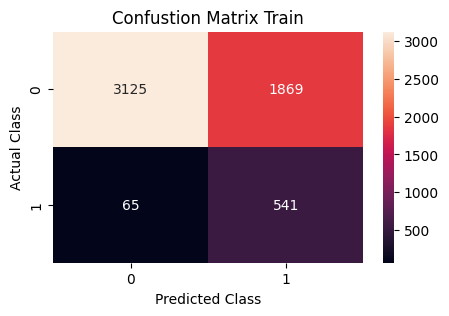

Predict Test:


C:\Users\tanap\AppData\Local\Temp\ipykernel_22164\2757043637.py:85: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


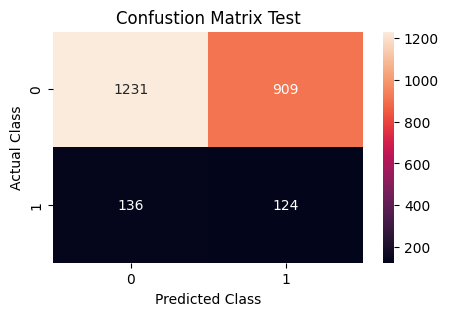

C:\Users\tanap\AppData\Local\Temp\ipykernel_22164\2757043637.py:85: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


Predict OOT1:


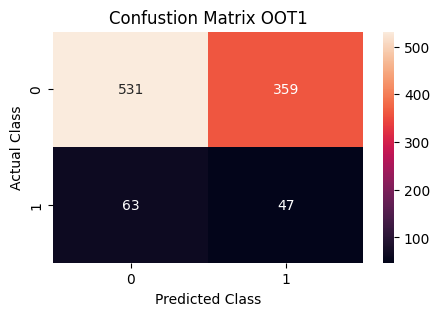

Predict OOT2:


C:\Users\tanap\AppData\Local\Temp\ipykernel_22164\2757043637.py:85: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


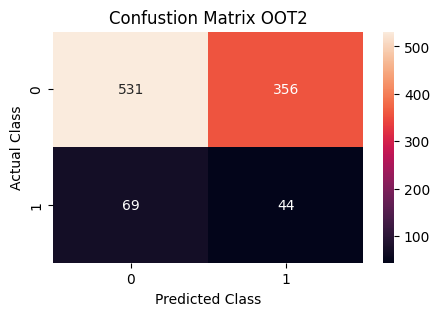

C:\Users\tanap\AppData\Local\Temp\ipykernel_22164\2757043637.py:85: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


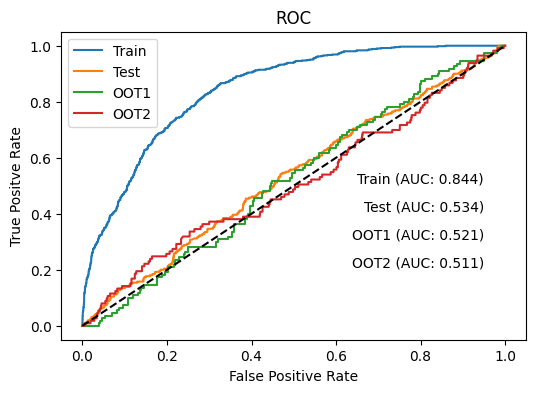

In [36]:
score_list_df = evaluate_model(df_train, df_test, df_oot1, df_oot2, model=lgb_model)

In [37]:
score_list_df

,model_name,parameters,rows,columns,%_target,accuracy,auc,precision,recall,f1-score
0,Train: LightGBM,<bound method LGBMModel.get_params of LGBMClas...,5600,18,10,0.66,0.84,0.22,0.89,0.36
1,Test: LightGBM,<bound method LGBMModel.get_params of LGBMClas...,2400,18,10,0.56,0.53,0.12,0.48,0.19
2,OOT1: LightGBM,<bound method LGBMModel.get_params of LGBMClas...,1000,18,11,0.58,0.52,0.12,0.43,0.18
3,OOT2: LightGBM,<bound method LGBMModel.get_params of LGBMClas...,1000,18,11,0.57,0.51,0.11,0.39,0.17


Save Model

In [48]:
file_path_model = r'.pkl'
joblib.dump(lgb_model, file_path_model)

['C:\\Users\\tanap\\llm\\MADT6004_Collaborative_Filtering\\propensity_to_use_campaign_model.pkl']

Load Model

In [39]:
lgb_model_load = joblib.load(file_path_model)

In [40]:
X_all_customers, y_all_customers = prepare_X_y(df=df_oot1)
X_all_customers.head()

,Total_Credit_Limit,Average_Monthly_Spend,Number_of_Transactions_Per_Month,Number_of_Merchants_Per_Month,Spend_Category,Credit_Limit_Utilization,Number_of_Overdue_Payments_12_Months,Number_of_Payments_in_Full_12_Months,Number_of_Late_Payments_12_Months,Average_Payment_Amt,Days_Since_Last_Transaction,Avg_Spend_Per_Transaction,High_Value_Transactions,Num_Spend_Categories,Avg_Days_Between_Transactions,Times_Credit_Limit_Exceeded,Previous_Month_Payment,Times_Payment_Missed
8,82217.29,18527.22,22,2,Entertainment,0.37,1,5,0,16299.24,28,842.15,1,2,1.36,0,24504.11,0
18,150139.33,28001.55,11,9,Entertainment,0.44,1,8,1,21558.01,8,2545.60,1,3,2.73,0,31476.59,0
28,269555.67,28535.73,44,15,Dining,0.67,0,7,0,24551.33,5,648.54,2,1,0.68,0,21174.80,2
38,367890.95,29847.02,31,15,Education,0.32,0,10,0,23545.81,15,962.81,2,5,0.97,0,16195.98,0
48,409803.74,19664.25,14,4,Health,0.79,0,6,0,22360.48,26,1404.59,2,1,2.14,0,15578.38,1


In [41]:
y_all_customers.head()

,Target
8,0
18,0
28,0
38,0
48,1


In [42]:
predicted_portfilio_scores = lgb_model_load.predict_proba(X_all_customers)[:, 1]

df_scores = pd.DataFrame({
    'Customer_ID': df_oot1['Customer_ID'].values,
    'Predicted_Score': predicted_portfilio_scores,
    'Actual': df_oot1['Target']
})

df_scores = df_scores.sort_values(by='Predicted_Score', ascending=False).reset_index(drop=True)
df_scores['Bin'] = pd.qcut(df_scores['Predicted_Score'], 10, labels=False) + 1

bin_pivot = df_scores.groupby('Bin').agg(
    count_target_0=('Actual', lambda x: (x == 0).sum()),
    count_target_1=('Actual', lambda x: (x == 1).sum()),
    count_all=('Actual', 'count'),
    sum_pred_score=('Predicted_Score', 'sum')
).reset_index().sort_values(by='Bin', ascending=False)

bin_pivot['%_correct'] = bin_pivot['count_target_1'] / bin_pivot['count_all'] * 100
bin_pivot['%_incorrect'] = bin_pivot['count_target_0'] / bin_pivot['count_all'] * 100
bin_pivot['%_population'] = bin_pivot['count_all'] / df_scores.shape[0] * 100
bin_pivot['cumsum_correct'] = bin_pivot['count_target_1'].cumsum()
bin_pivot['cumsum_population'] = bin_pivot['count_all'].cumsum()
bin_pivot['%_cumsum_correct'] = bin_pivot['cumsum_correct'] / bin_pivot['count_target_1'].sum() * 100
bin_pivot['%_cumsum_population'] = bin_pivot['cumsum_population'] / bin_pivot['count_all'].sum() * 100
bin_pivot['%_lift_at_decile'] = bin_pivot['count_target_1'] / (bin_pivot['count_target_1'].sum()/10) * 100

total_correct = bin_pivot['count_target_1'].sum()
bin_pivot['total_lift'] = bin_pivot['cumsum_correct'] / total_correct * 100

bin_pivot['random'] = 100
bin_pivot

,Bin,count_target_0,count_target_1,count_all,sum_pred_score,%_correct,%_incorrect,%_population,cumsum_correct,cumsum_population,%_cumsum_correct,%_cumsum_population,%_lift_at_decile,total_lift,random
9,10,92,8,100,56.89,8.00,92.00,10.00,8,100,7.27,10.00,72.73,7.27,100
8,9,87,13,100,53.74,13.00,87.00,10.00,21,200,19.09,20.00,118.18,19.09,100
7,8,90,10,100,52.29,10.00,90.00,10.00,31,300,28.18,30.00,90.91,28.18,100
6,7,84,16,100,50.98,16.00,84.00,10.00,47,400,42.73,40.00,145.45,42.73,100
5,6,89,11,100,49.20,11.00,89.00,10.00,58,500,52.73,50.00,100.00,52.73,100
4,5,88,12,100,47.12,12.00,88.00,10.00,70,600,63.64,60.00,109.09,63.64,100
3,4,88,12,100,44.32,12.00,88.00,10.00,82,700,74.55,70.00,109.09,74.55,100
2,3,90,10,100,40.80,10.00,90.00,10.00,92,800,83.64,80.00,90.91,83.64,100
1,2,88,12,100,36.13,12.00,88.00,10.00,104,900,94.55,90.00,109.09,94.55,100
0,1,94,6,100,27.19,6.00,94.00,10.00,110,1000,100.00,100.00,54.55,100.00,100


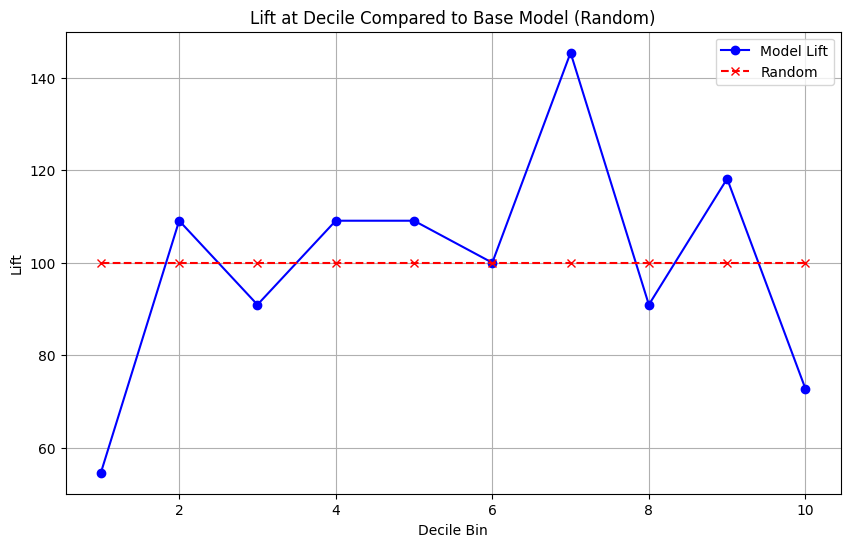

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(bin_pivot['Bin'], bin_pivot['%_lift_at_decile'], marker='o', linestyle='-', color='b', label='Model Lift')
plt.plot(bin_pivot['Bin'], bin_pivot['random'], marker='x', linestyle='--', color='r', label='Random')
plt.title('Lift at Decile Compared to Base Model (Random)')
plt.xlabel('Decile Bin')
plt.ylabel('Lift')
plt.legend()
plt.grid(True)
plt.show()

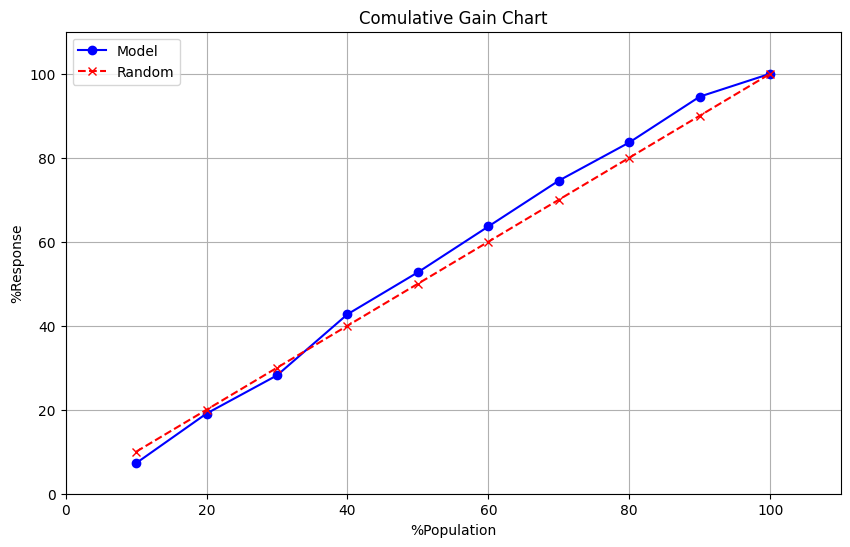

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(bin_pivot['%_cumsum_population'], bin_pivot['%_cumsum_correct'], marker='o', linestyle='-', color='b', label='Model')
plt.plot(bin_pivot['%_cumsum_population'], bin_pivot['%_cumsum_population'], marker='x', linestyle='--', color='r', label='Random')
plt.title('Comulative Gain Chart')
plt.xlabel('%Population')
plt.ylabel('%Response')
plt.legend()
plt.xlim(0, 110)
plt.ylim(0, 110)
plt.grid(True)
plt.show()

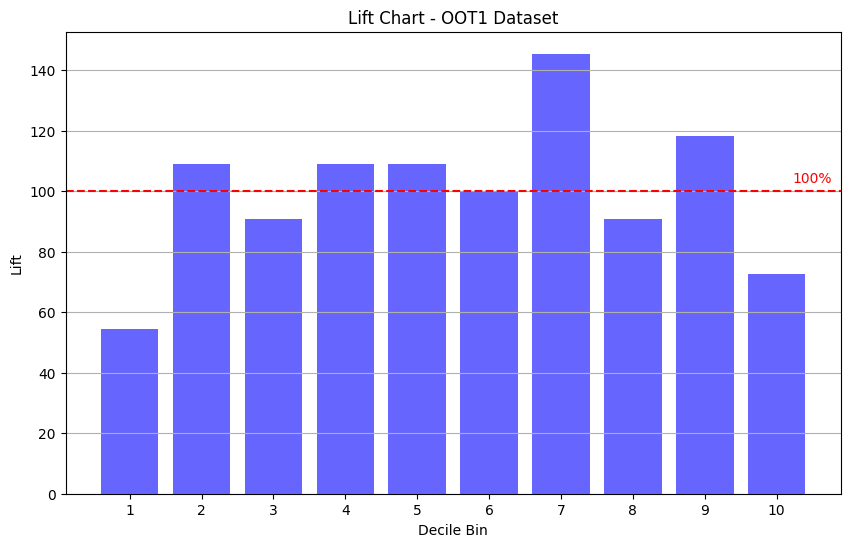

In [46]:
random_line = 100

plt.figure(figsize=(10, 6))
plt.bar(bin_pivot['Bin'], bin_pivot['%_lift_at_decile'], color='b', alpha=0.6)
plt.axhline(y=random_line, color='r', linestyle='--', label='Average Line')
plt.text(10.5, random_line + 2, f'{random_line}%', color='r', ha='center', va='bottom')
plt.title('Lift Chart - OOT1 Dataset')
plt.xlabel('Decile Bin')
plt.ylabel('Lift')
plt.xticks(bin_pivot['Bin'])
plt.grid(axis='y')
plt.show()

Save Result

In [47]:
print(df_scores.shape)
df_scores.head()

(1000, 4)


,Customer_ID,Predicted_Score,Actual,Bin
0,66000477,0.62,0,10
1,66000253,0.62,0,10
2,66000440,0.62,0,10
3,66000607,0.62,0,10
4,66000241,0.61,0,10


In [ ]:
# file_path_model_result_oot1 = r''
# df_scores.to_csv(file_path_model_result_oot1, index=False)